In [1]:
%matplotlib inline

In [14]:
import math
import numpy as np
from numpy.random import randn

def compute_rlinear_data(x0=0., x_std=0., dx_std=0., dxdr=1., layers=[0.,1.,2.] ):
    "returns track, measurements 1D ndarrays"
    x=x0
    xs, zs, rs = [], [], []  
    for i in range(len(layers)):
        if (i+1) < len(layers):
            dr = layers[i+1]-layers[i]
        #print(i, dr)
        v = dxdr + (randn() * dx_std)
        x += v*dr
        z = x + randn() * x_std
        #print(r, x, z, v)
        xs.append([dr,x])
        zs.append([dr,z])
    return np.array(xs), np.array(zs)

In [15]:
from kf_book.mkf_internal import plot_track_ellipses

def plot_covariances(count, R, Q=0, P=20., title=''):    
    track, zs = compute_dog_data(R, Q, count)
    f = pos_vel_filter(x=(0., 0.), R=R, Q=Q, P=P)

    xs, cov = [], []
    for z in zs:
        f.predict()
        f.update(z)

        xs.append(f.x[0])
        cov.append(f.P)
    plot_track_ellipses(count, zs, xs, cov, title)

In [16]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

In [17]:
from kf_book.mkf_internal import plot_track
from filterpy.common import Saver

def run(ts, truth, zs, x0=(0.,0.), P=0, R=0, Q=0,
        do_plot=True, **kwargs):
    """
    track is the actual position, zs are the 
    corresponding measurements. 
    """

    # create the Kalman filter
    #Q = Q_discrete_white_noise(dim=2, dt=5., var=Q)
    #print(Q)
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q)  
    #s = Saver(kf)
    # run the kalman filter and store the results
    xs, cov = [], []
    for (dt,z) in zs:
        #print (dt,z)
        kf.F = np.array([[1., dt],
                         [0.,  1.]])  # update state transition matrix
        #kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q*dt) # MS proportional to r. Replace with better function
        #print(kf.Q)
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)
        #s.save()

    xs, cov = np.array(xs), np.array(cov)
    print("kalman gain", kf.K)
    if do_plot:
        plot_track(ts, xs[:, 0], truth[:,1], zs[:,1], cov, **kwargs)
    return xs,zs,cov,kf

In [18]:
rlayers=[25., 30., 35., 40., 45., 50., 55., 60., 80., 85., 105.] #detector layers radii cm 
#rlayers=[25., 30., 35., 40., 45., 50., 55., 60.] #detector layers radii cm 
#rlayers=[0., 5., 10., 15., 20., 25., 30., 35., 40., 45.] #detector layers radii cm 
#rlayers=list(range(8))
dphidr=1  #degrees/cm
phi_std=0.001*360 #stddev in phi dominated by MS
dphi_std=0.1*dphidr
(true_phis, zphis) = compute_rlinear_data(dxdr=dphidr, x_std=phi_std, dx_std=dphi_std, layers=rlayers)
(true_zs, z_zs) = compute_rlinear_data(dxdr=10, x_std=1., dx_std=0.1, layers=rlayers)


In [19]:
P = np.diag([360**2, (360/100)**2]) #model covariance prior
R = (0.1*phi_std)**2  #sensor (co)variance 
Q = phi_std**2 #noise (co)variance (MS?)
print (R,Q)
xs, zs, cov, kf = run(rlayers, true_phis, zphis, x0=(0., dphidr), R=R, Q=Q, y_lim=[0.,100.], title="KF R-Phi")

from filterpy.stats import plot_covariance_ellipse
import kf_book.book_plots as bp
for i in range(len(cov)):
    x = xs[i]
    P = cov[i]
    plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')
    
bp.set_labels(x='Phy', y='dPhi/dr')
print("rlayers", rlayers)
print("Phi truth", true_phis)
print("Phi meas", zphis)
print("Phi filter", xs)

0.0012959999999999998 0.1296
kalman gain [[0.9999737]
 [0.051278 ]]


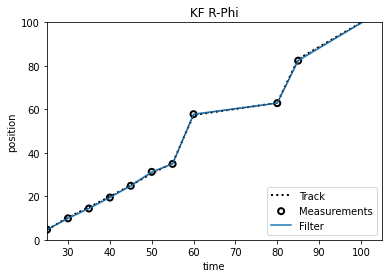

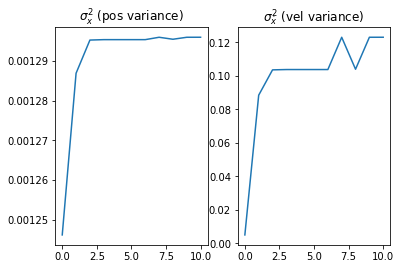

rlayers [25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 80.0, 85.0, 105.0]
Phi truth [[  5.           4.55799105]
 [  5.          10.30352763]
 [  5.          14.96192723]
 [  5.          19.85899246]
 [  5.          25.06787589]
 [  5.          30.53057226]
 [  5.          35.24815647]
 [ 20.          57.39641642]
 [  5.          62.95705264]
 [ 20.          83.11977568]
 [ 20.         105.41242591]]
Phi meas [[  5.           4.68144263]
 [  5.           9.86215141]
 [  5.          14.39574748]
 [  5.          19.42899513]
 [  5.          24.8406222 ]
 [  5.          31.24336177]
 [  5.          34.90395664]
 [ 20.          57.77423377]
 [  5.          62.84533136]
 [ 20.          82.38124922]
 [ 20.         105.39754247]]
Phi filter [[  4.69369484   0.38738968]
 [  9.83944965   2.0027072 ]
 [ 14.39888569   0.77285947]
 [ 19.42842035   1.03152749]
 [ 24.84049692   1.08800012]
 [ 31.24288791   1.30160177]
 [ 34.9053577    0.67003705]
 [ 57.77393863   1.15773688]
 [ 62.84562994   1.000

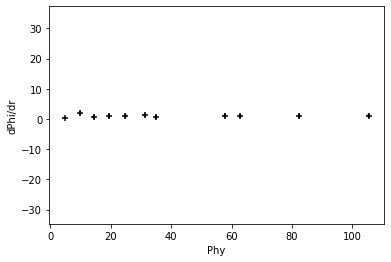

In [19]:
Ms, Ps, _, _ = kf.rts_smoother(xs, cov)

kalman gain [[0.9999737]
 [0.051278 ]]


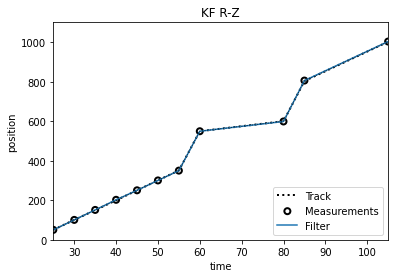

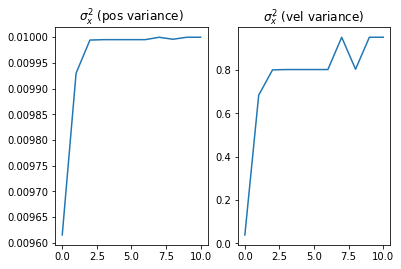

rlayers [25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 80.0, 85.0, 105.0]
Z truth [[   5.           50.3515404 ]
 [   5.          100.88607485]
 [   5.          150.06592987]
 [   5.          199.95549013]
 [   5.          250.13169843]
 [   5.          300.69916522]
 [   5.          350.69854483]
 [  20.          549.30062822]
 [   5.          599.94473106]
 [  20.          803.18768281]
 [  20.         1002.03415827]]
Z meas [[   5.           50.29670783]
 [   5.          100.68851814]
 [   5.          151.13868986]
 [   5.          202.28701385]
 [   5.          250.36500415]
 [   5.          300.31953786]
 [   5.          350.0355198 ]
 [  20.          549.19773941]
 [   5.          598.60515487]
 [  20.          805.54044351]
 [  20.         1002.96204569]]
Z filter [[  50.28529599   10.57059198]
 [ 100.70572786    9.34605406]
 [ 151.13656061   10.18049574]
 [ 202.28689159   10.23551583]
 [ 250.36652952    9.5479294 ]
 [ 300.3184486    10.03894112]
 [ 350.03575486    9.93298279]

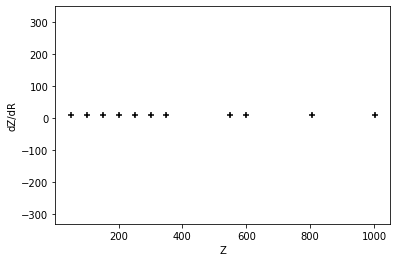

In [10]:
P = np.diag([1**2, (0.1)**2]) #model covariance prior
R = 0.1**2  #sensor (co)variance 1%**2
Q = 1**2 #noise (co)variance (MS?)
xs, zs, cov = run(rlayers, true_zs, z_zs, x0=(0., 10), R=R, Q=Q, y_lim=[0.,1100.], title="KF R-Z")

from filterpy.stats import plot_covariance_ellipse
import kf_book.book_plots as bp
import matplotlib.pyplot as plt
plt.y_lim=(-20.,20.)
for i in range(len(cov)):
    x = xs[i]
    P = cov[i]
    plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')
    
bp.set_labels(x='Z', y='dZ/dR')
print("rlayers", rlayers)
print("Z truth", true_zs)
print("Z meas", z_zs)
print("Z filter", xs)

In [ ]:
len(cov)
